In [2]:
!pip install 'monai[einops,pynrrd]'
!pip install pyradiomics
!pip install xgboost
!pip install tabulate
!pip install nibabel

  Using cached monai-1.4.0-py3-none-any.whl.metadata (11 kB)
  Using cached torch-2.5.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
  Using cached pynrrd-1.0.0-py2.py3-none-any.whl.metadata (3.9 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none

In [3]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

from monai.data import CacheDataset, DataLoader, NrrdReader, Dataset
from monai.transforms import Compose, LoadImaged
from monai.utils import first

#### uploading data

In [4]:
import glob
file_image = glob.glob('./data_spb/mri' + "/*")
file_image.sort()
file_label = glob.glob('./data_spb/seg' + "/*")
file_label.sort()

image, label = [], []
for i in range(len(file_image)):
    image.append(file_image[i])
    label.append(file_label[i])

data = {
    'image': image,
    'label': label
}
file= []
for i in range(len(file_image)):
    file.append({"image": data['image'][i], "label": data['label'][i]})

## Data visualization

In [17]:
transform = Compose([
    LoadImaged(keys=['image']),
    LoadImaged(keys=['label'], reader="itkreader"),
])

file = [{'image':'./example/t2_tirm.nii.gz', 'label': './example/2.nrrd'}]
ds_5 = Dataset(
    data=file,
    transform = transform,
)

/opt/conda/lib/python3.11/site-packages/monai/transforms/io/array.py:214: UserWarning: required package for reader itkreader is not installed, or the version doesn't match requirement.
  warnings.warn(


mri shape = torch.Size([1, 464, 512, 31])
seg shape = torch.Size([1, 464, 512, 31])


(-0.5, 511.5, 463.5, -0.5)

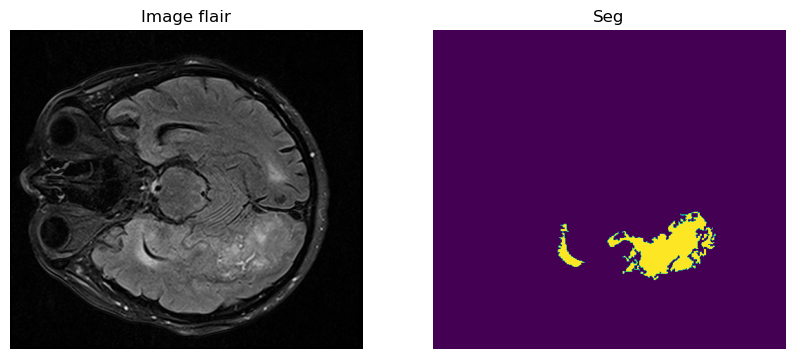

In [18]:
check_loader = DataLoader(ds_5, batch_size=1)
data = first(check_loader)

mri = data['image']
seg = data['label']

print('mri shape =', mri.shape)
print('seg shape =', seg.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5))
ax1.imshow(mri[0,:,:,11], cmap='gray')
ax1.set_title('Image flair')
ax1.axis('off')
ax2.imshow(seg[0, :,:,11]) 
ax2.set_title('Seg')
ax2.axis('off')

# Radiomics

In [19]:
import SimpleITK as sitk

m = mri[0].detach().numpy()
l = seg[0].detach().numpy()

mr = sitk.GetImageFromArray(m)
la = sitk.GetImageFromArray(l)

In [20]:
import six
import radiomics.featureextractor as FEE

extractor = FEE.RadiomicsFeatureExtractor(correctMask=True)
result = extractor.execute(mr, la)

feature = np.array([])
for key, value in six.iteritems(result):
    if key.startswith("original_"):
        feature = np.append(feature, result[key])

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


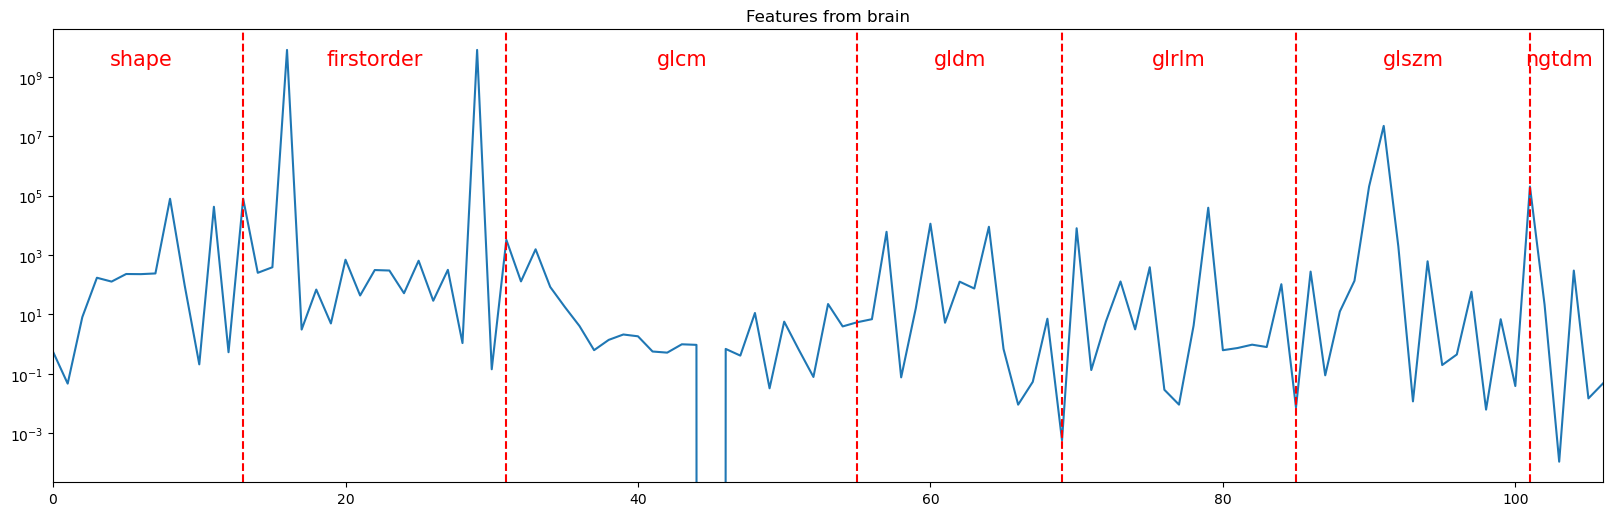

In [73]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
plt.plot(feature)
plt.yscale('log')
plt.title("Features from brain")
plt.xlim(0, 106)

# Добавление вертикальных линий на указанных позициях
for x in [13, 31, 55, 69, 85, 101]:
    plt.axvline(x=x, color='r', linestyle='--')  # Красная пунктирная линия
plt.text(6, plt.ylim()[1] * 0.1, 'shape', fontsize=15, ha='center', va='center', color='red')
plt.text(22, plt.ylim()[1] * 0.1, 'firstorder', fontsize=15, ha='center', va='center', color='red')
plt.text(43, plt.ylim()[1] * 0.1, 'glcm', fontsize=15, ha='center', va='center', color='red')
plt.text(62, plt.ylim()[1] * 0.1, 'gldm', fontsize=15, ha='center', va='center', color='red')
plt.text(77, plt.ylim()[1] * 0.1, 'glrlm', fontsize=15, ha='center', va='center', color='red')
plt.text(93, plt.ylim()[1] * 0.1, 'glszm', fontsize=15, ha='center', va='center', color='red')
plt.text(103, plt.ylim()[1] * 0.1, 'ngtdm', fontsize=15, ha='center', va='center', color='red')
plt.show()

In [38]:
import radiomics
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm, gldm, ngtdm

In [40]:
firstOrderFeatures = firstorder.RadiomicsFirstOrder(mr, la)
firstOrderFeatures.enableAllFeatures()  # On the feature class level, all features are disabled by default.
firstOrderFeatures.execute()
print('First Order Features')
for (key,val) in six.iteritems(firstOrderFeatures.featureValues):
    print("\t%s: %s" % (key, val))

First Order Features
	10Percentile: 253.0
	90Percentile: 389.0
	Energy: 7992744433.0
	Entropy: 3.112681535711276
	InterquartileRange: 69.0
	Kurtosis: 4.996093413084909
	Maximum: 697.0
	MeanAbsoluteDeviation: 43.601055948924156
	Mean: 313.0590493323536
	Median: 302.0
	Minimum: 52.0
	Range: 645.0
	RobustMeanAbsoluteDeviation: 29.02730784901244
	RootMeanSquared: 318.2115270332906
	Skewness: 1.0939103347400707
	TotalEnergy: 7992744433.0
	Uniformity: 0.14348597255197496
	Variance: 3252.607567981629


In [41]:
shapeFeatures = shape.RadiomicsShape(mr, la)
shapeFeatures.enableAllFeatures()
shapeFeatures.execute()
print('Shape Features')
for (key,val) in six.iteritems(shapeFeatures.featureValues):
    print("\t%s: %s" % (key, val))

Shape Features
	Elongation: 0.5558189151767738
	Flatness: 0.04723480735077578
	LeastAxisLength: 8.145355083717268
	MajorAxisLength: 172.4439145740157
	Maximum2DDiameterColumn: 128.06248474865697
	Maximum2DDiameterRow: 230.471256342304
	Maximum2DDiameterSlice: 228.0548179714693
	Maximum3DDiameter: 240.57223447438818
	MeshVolume: 78268.375
	MinorAxisLength: 95.84758952736568
	Sphericity: 0.20974347965996873
	SurfaceArea: 42187.76652438383
	SurfaceVolumeRatio: 0.5390142126290961
	VoxelVolume: 78934.0


In [42]:
glcmFeatures = glcm.RadiomicsGLCM(mr, la)
glcmFeatures.enableAllFeatures()
glcmFeatures.execute()
print('GLCM Features')
for (key,val) in six.iteritems(glcmFeatures.featureValues):
    print("\t%s: %s" % (key, val))

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM Features
	Autocorrelation: 129.93964353099307
	ClusterProminence: 1563.6375159512647
	ClusterShade: 84.41657425848537
	ClusterTendency: 17.876385641477693
	Contrast: 4.1032722624605675
	Correlation: 0.6313392068712209
	DifferenceAverage: 1.3991270146405266
	DifferenceEntropy: 2.1233842862442924
	DifferenceVariance: 1.8471778775149637
	Id: 0.5683371598390319
	Idm: 0.5208795070312806
	Idmn: 0.9941096889132486
	Idn: 0.9514575244534528
	Imc1: -0.174876074454436
	Imc2: 0.6944731411903179
	InverseVariance: 0.4140068635727904
	JointAverage: 11.246690765676606
	JointEnergy: 0.03283800395493554
	JointEntropy: 5.747867563842822
	MCC: 0.6510164578365265
	MaximumProbability: 0.07908981346680476
	SumAverage: 22.493381531353222
	SumEntropy: 3.9701892660129343
	SumSquares: 5.494914475984567


In [43]:
glrlmFeatures = glrlm.RadiomicsGLRLM(mr, la)
glrlmFeatures.enableAllFeatures()
glrlmFeatures.execute()
print('GLRLM Features')
for (key,val) in six.iteritems(glrlmFeatures.featureValues):
    print("\t%s: %s" % (key, val))

GLRLM Features
	GrayLevelNonUniformity: 7982.709822900239
	GrayLevelNonUniformityNormalized: 0.1352756623209004
	GrayLevelVariance: 5.780732696708683
	HighGrayLevelRunEmphasis: 129.07744335479558
	LongRunEmphasis: 3.159800639583039
	LongRunHighGrayLevelEmphasis: 390.0977597693022
	LongRunLowGrayLevelEmphasis: 0.029323044856580247
	LowGrayLevelRunEmphasis: 0.0092723096429576
	RunEntropy: 4.273223685987554
	RunLengthNonUniformity: 39155.55007303728
	RunLengthNonUniformityNormalized: 0.6284406174008156
	RunPercentage: 0.7439584385007143
	RunVariance: 0.9649085604591341
	ShortRunEmphasis: 0.8044810484525834
	ShortRunHighGrayLevelEmphasis: 104.69527677149497
	ShortRunLowGrayLevelEmphasis: 0.007483235698595401


In [44]:
glszmFeatures = glszm.RadiomicsGLSZM(mr, la)
glszmFeatures.enableAllFeatures()
glszmFeatures.execute()
print('GLSZM Features')
for (key,val) in six.iteritems(glszmFeatures.featureValues):
    print("\t%s: %s" % (key, val))

GLSZM Features
	GrayLevelNonUniformity: 277.6716224951519
	GrayLevelNonUniformityNormalized: 0.08974519149810986
	GrayLevelVariance: 12.600794581668382
	HighGrayLevelZoneEmphasis: 136.0879120879121
	LargeAreaEmphasis: 203312.0523594053
	LargeAreaHighGrayLevelEmphasis: 22214952.02456367
	LargeAreaLowGrayLevelEmphasis: 1943.8846110778463
	LowGrayLevelZoneEmphasis: 0.011915506230414154
	SizeZoneNonUniformity: 616.6961861667744
	SizeZoneNonUniformityNormalized: 0.1993200343137603
	SmallAreaEmphasis: 0.4514810749256173
	SmallAreaHighGrayLevelEmphasis: 58.34096431227778
	SmallAreaLowGrayLevelEmphasis: 0.006304431063838328
	ZoneEntropy: 6.9417844271557
	ZonePercentage: 0.039197304076823675
	ZoneVariance: 202661.19232628657


In [78]:
gldmFeatures = gldm.RadiomicsGLDM(mr, la)
gldmFeatures.enableAllFeatures()
gldmFeatures.execute()
print('GLDM Features')
for (key,val) in six.iteritems(gldmFeatures.featureValues):
    print("\t%s: %s" % (key, val))

GLDM Features
	DependenceEntropy: 6.952443258472546
	DependenceNonUniformity: 6060.400030405149
	DependenceNonUniformityNormalized: 0.07677806813800325
	DependenceVariance: 16.208374815076258
	GrayLevelNonUniformity: 11325.92175741759
	GrayLevelVariance: 5.285382356046036
	HighGrayLevelEmphasis: 127.20576684318544
	LargeDependenceEmphasis: 74.83925811437403
	LargeDependenceHighGrayLevelEmphasis: 8960.377834646666
	LargeDependenceLowGrayLevelEmphasis: 0.6920768822193917
	LowGrayLevelEmphasis: 0.009254251096187511
	SmallDependenceEmphasis: 0.05419772377572615
	SmallDependenceHighGrayLevelEmphasis: 7.20912798066449
	SmallDependenceLowGrayLevelEmphasis: 0.0005838034980498054


In [80]:
ngtdmFeatures = ngtdm.RadiomicsNGTDM(mr, la)
ngtdmFeatures.enableAllFeatures()
ngtdmFeatures.execute()
print('NGTDM Features')
for (key,val) in six.iteritems(ngtdmFeatures.featureValues):
    print("\t%s: %s" % (key, val))

NGTDM Features
	Busyness: 21.46389480650035
	Coarseness: 0.00011148308238704428
	Complexity: 300.83487424831407
	Contrast: 0.015028120616833502
	Strength: 0.0481764899156497


## Calculate Features using Laplacian of Gaussian Filter

### Calculate Firstorder on LoG filtered images

In [99]:
sigma_1 = np.array([])
for logImage, imageTypename, inputSettings in imageoperations.getLoGImage(mr, la, sigma=[1.0]):
    logFirstorderFeatures = FEE.RadiomicsFeatureExtractor(correctMask=True)
    logFirstorderFeatures.enableAllFeatures()
    result = logFirstorderFeatures.execute(logImage, la)
    for key, value in six.iteritems(result):
        if key.startswith("original_"):
            sigma_1 = np.append(sigma_1, result[key])

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [100]:
sigma_3 = np.array([])
for logImage, imageTypename, inputSettings in imageoperations.getLoGImage(mr, la, sigma=[3.0]):
    logFirstorderFeatures = FEE.RadiomicsFeatureExtractor(correctMask=True)
    logFirstorderFeatures.enableAllFeatures()
    result = logFirstorderFeatures.execute(logImage, la)
    for key, value in six.iteritems(result):
        if key.startswith("original_"):
            sigma_3 = np.append(sigma_3, result[key])

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [101]:
sigma_5 = np.array([])
for logImage, imageTypename, inputSettings in imageoperations.getLoGImage(mr, la, sigma=[5.0]):
    logFirstorderFeatures = FEE.RadiomicsFeatureExtractor(correctMask=True)
    logFirstorderFeatures.enableAllFeatures()
    result = logFirstorderFeatures.execute(logImage, la)
    for key, value in six.iteritems(result):
        if key.startswith("original_"):
            sigma_5 = np.append(sigma_5, result[key])

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


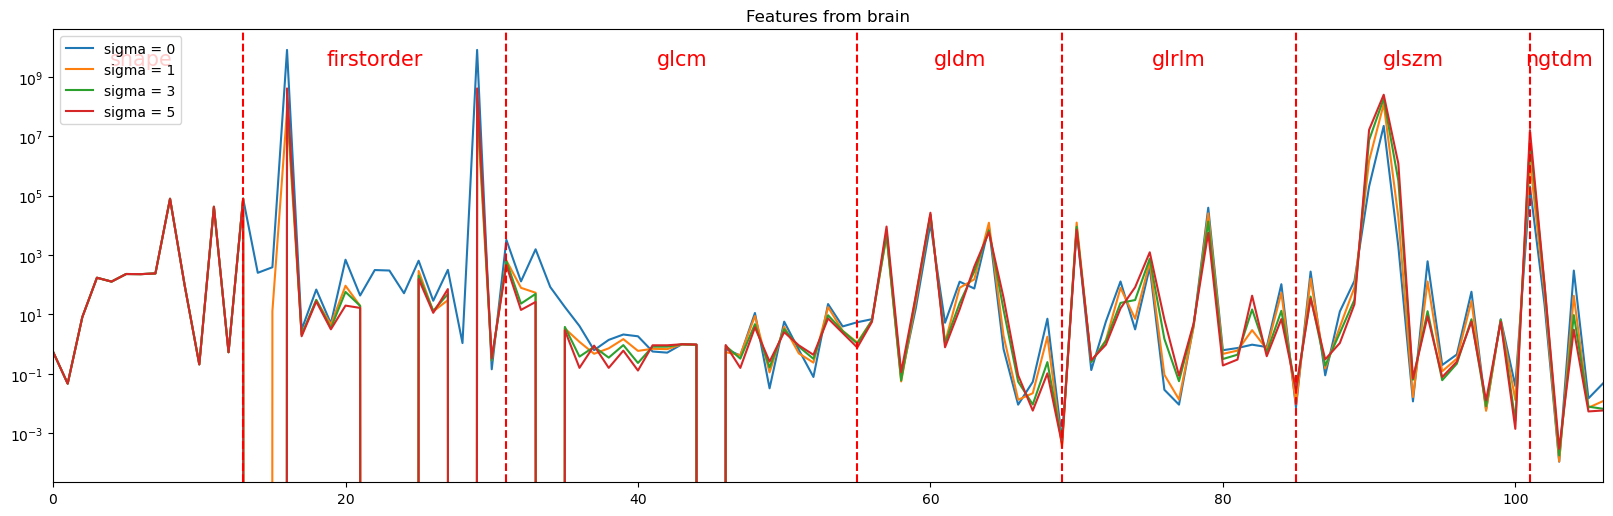

In [102]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
plt.plot(feature, label = 'sigma = 0')
plt.plot(sigma_1, label = 'sigma = 1')
plt.plot(sigma_3, label = 'sigma = 3')
plt.plot(sigma_5, label = 'sigma = 5')
plt.legend(loc='best')
plt.yscale('log')
plt.title("Features from brain")
plt.xlim(0, 106)

# Добавление вертикальных линий на указанных позициях
for x in [13, 31, 55, 69, 85, 101]:
    plt.axvline(x=x, color='r', linestyle='--')  # Красная пунктирная линия
plt.text(6, plt.ylim()[1] * 0.1, 'shape', fontsize=15, ha='center', va='center', color='red')
plt.text(22, plt.ylim()[1] * 0.1, 'firstorder', fontsize=15, ha='center', va='center', color='red')
plt.text(43, plt.ylim()[1] * 0.1, 'glcm', fontsize=15, ha='center', va='center', color='red')
plt.text(62, plt.ylim()[1] * 0.1, 'gldm', fontsize=15, ha='center', va='center', color='red')
plt.text(77, plt.ylim()[1] * 0.1, 'glrlm', fontsize=15, ha='center', va='center', color='red')
plt.text(93, plt.ylim()[1] * 0.1, 'glszm', fontsize=15, ha='center', va='center', color='red')
plt.text(103, plt.ylim()[1] * 0.1, 'ngtdm', fontsize=15, ha='center', va='center', color='red')
plt.show()

## Calculate Features using Wavelet filter

### Calculate Firstorder on filtered images

In [124]:
Features_LLH, Features_LHL, Features_LHH, Features_HLL = np.array([]), np.array([]), np.array([]), np.array([])
Features_HLH, Features_HHL, Features_HHH, Features_LLL = np.array([]), np.array([]), np.array([]), np.array([])

for decompositionImage, decompositionName, inputSettings in imageoperations.getWaveletImage(mr, la):
    waveletFirstOrderFeaturs = FEE.RadiomicsFeatureExtractor(correctMask=True)
    waveletFirstOrderFeaturs.enableAllFeatures()
    result = waveletFirstOrderFeaturs.execute(decompositionImage, la)
    if 'LLH' in decompositionName:
        for key, value in six.iteritems(result):
            if key.startswith("original_"):
                Features_LLH = np.append(Features_LLH, result[key])
    if 'LHL' in decompositionName:
        for key, value in six.iteritems(result):
            if key.startswith("original_"):
                Features_LHL = np.append(Features_LHL, result[key])
    if 'LHH' in decompositionName:
        for key, value in six.iteritems(result):
            if key.startswith("original_"):
                Features_LHH = np.append(Features_LHH, result[key])
    if 'HLL' in decompositionName:
        for key, value in six.iteritems(result):
            if key.startswith("original_"):
                Features_HLL = np.append(Features_HLL, result[key])
    
    if 'HLH' in decompositionName:
        for key, value in six.iteritems(result):
            if key.startswith("original_"):
                Features_HLH = np.append(Features_HLH, result[key])
    if 'HHL' in decompositionName:
        for key, value in six.iteritems(result):
            if key.startswith("original_"):
                Features_HHL = np.append(Features_HHL, result[key])
    if 'HHH' in decompositionName:
        for key, value in six.iteritems(result):
            if key.startswith("original_"):
                Features_HHH = np.append(Features_HHH, result[key])
    if 'LLL' in decompositionName:
        for key, value in six.iteritems(result):
            if key.startswith("original_"):
                Features_LLL = np.append(Features_LLL, result[key])

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to T

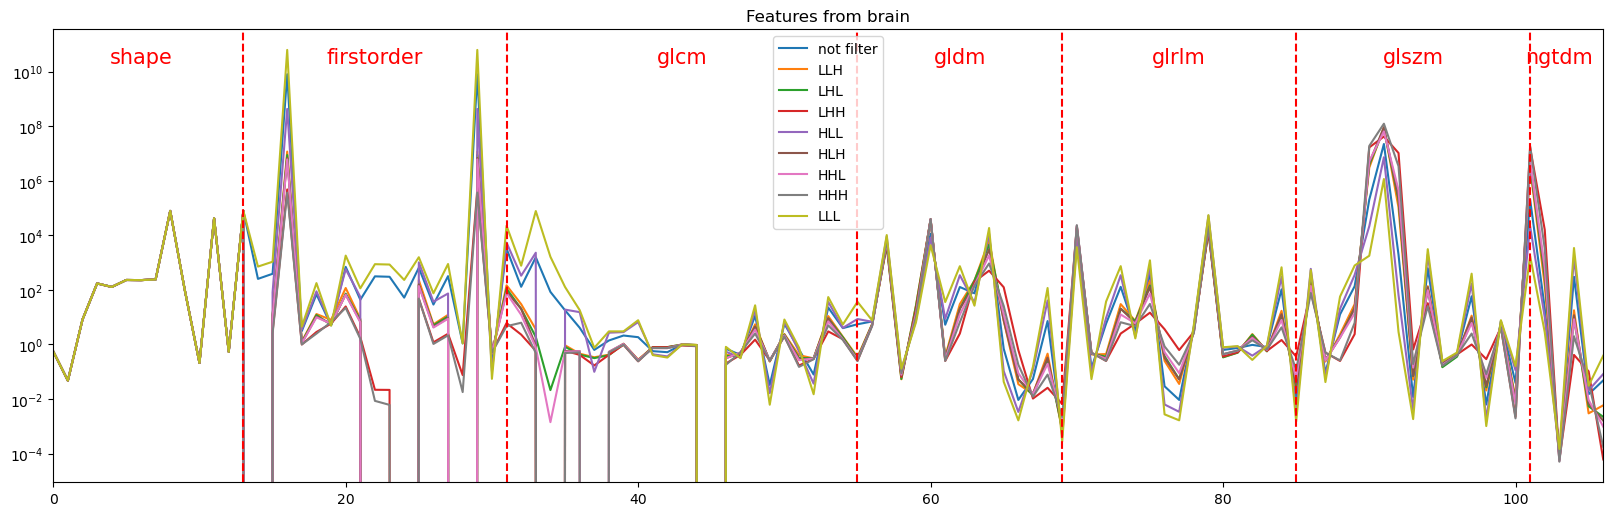

In [125]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
plt.plot(feature, label = 'not filter')
plt.plot(Features_LLH, label = 'LLH')
plt.plot(Features_LHL, label = 'LHL')
plt.plot(Features_LHH, label = 'LHH')
plt.plot(Features_HLL, label = 'HLL')

plt.plot(Features_HLH, label = 'HLH')
plt.plot(Features_HHL, label = 'HHL')
plt.plot(Features_HHH, label = 'HHH')
plt.plot(Features_LLL, label = 'LLL')
plt.legend(loc='best')
plt.yscale('log')
plt.title("Features from brain")
plt.xlim(0, 106)

# Добавление вертикальных линий на указанных позициях
for x in [13, 31, 55, 69, 85, 101]:
    plt.axvline(x=x, color='r', linestyle='--')  # Красная пунктирная линия
plt.text(6, plt.ylim()[1] * 0.1, 'shape', fontsize=15, ha='center', va='center', color='red')
plt.text(22, plt.ylim()[1] * 0.1, 'firstorder', fontsize=15, ha='center', va='center', color='red')
plt.text(43, plt.ylim()[1] * 0.1, 'glcm', fontsize=15, ha='center', va='center', color='red')
plt.text(62, plt.ylim()[1] * 0.1, 'gldm', fontsize=15, ha='center', va='center', color='red')
plt.text(77, plt.ylim()[1] * 0.1, 'glrlm', fontsize=15, ha='center', va='center', color='red')
plt.text(93, plt.ylim()[1] * 0.1, 'glszm', fontsize=15, ha='center', va='center', color='red')
plt.text(103, plt.ylim()[1] * 0.1, 'ngtdm', fontsize=15, ha='center', va='center', color='red')
plt.show()

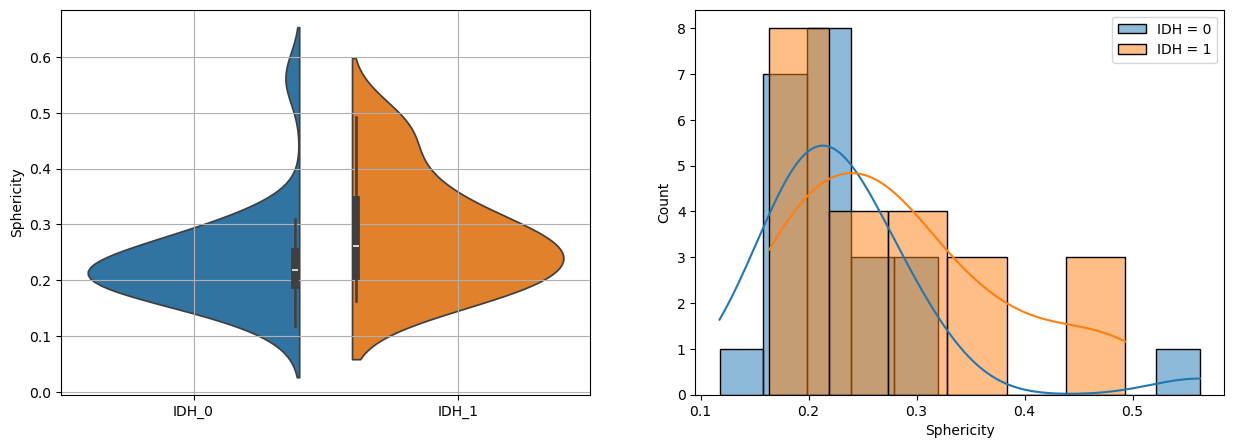

len train: 30
len test: 15


/tmp/ipykernel_977685/1586495699.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(d, bins = 1)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/li

,Accuracy,Precisione,Recall,F1_score
RidgeClassifier,0.600000,1.000000,0.250000,0.400000
RidgeClassifierCV,0.466667,0.000000,0.000000,0.000000
SGDClassifier,0.466667,0.000000,0.000000,0.000000
PassiveAggressiveClassifier,0.600000,1.000000,0.250000,0.400000
GaussianProcessClassifier,0.466667,0.000000,0.000000,0.000000
RandomForest,0.800000,0.857143,0.750000,0.800000
AdaBoostClassifier,0.800000,0.857143,0.750000,0.800000
BaggingClassifier,0.733333,0.833333,0.625000,0.714286
ExtraTreesClassifier,0.800000,0.857143,0.750000,0.800000
GradientBoostingClassifier,0.800000,0.857143,0.750000,0.800000


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best model: RandomForest
pred = [1 1 0 0 1 0 0 0 1 0 0 1 1 0 1]
true = [1 1 1 0 1 0 0 0 0 0 0 1 1 1 1]
---------  ---------
           Модель PR
accuracy   0.80
precision  0.86
recall     0.75
F1_score   0.80
---------  ---------


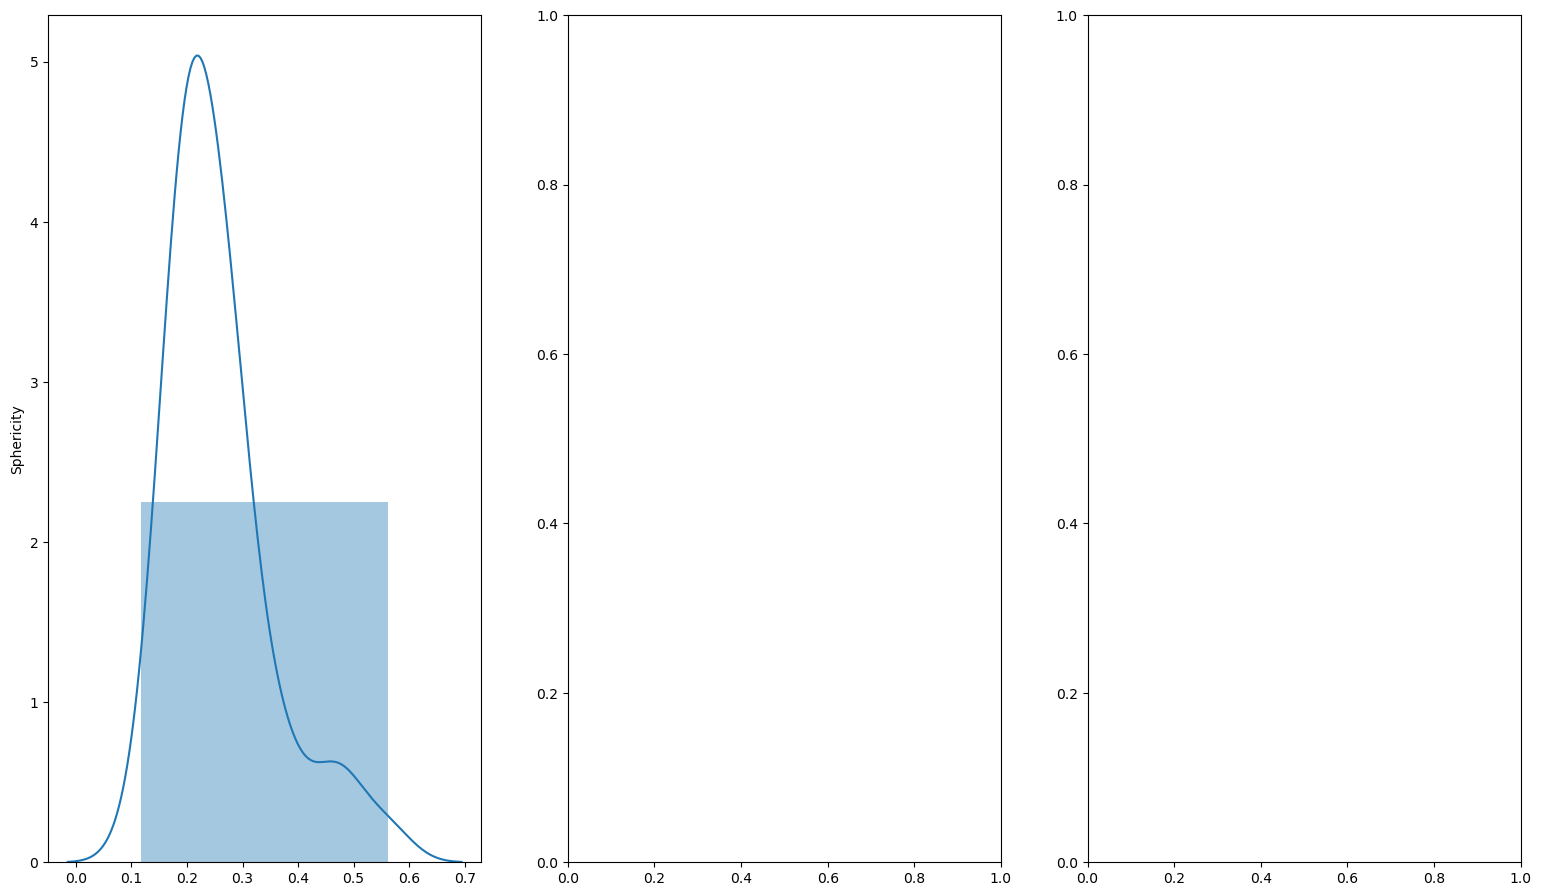

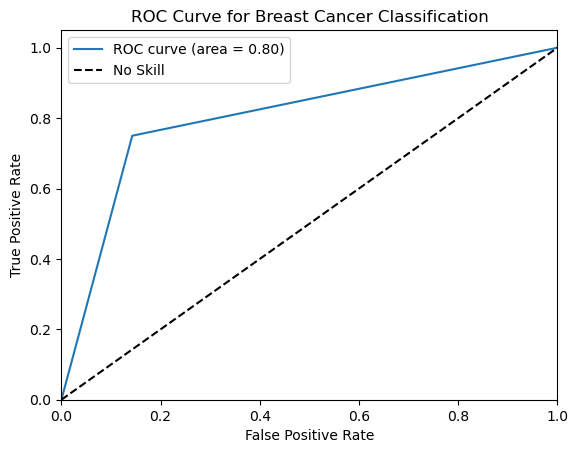

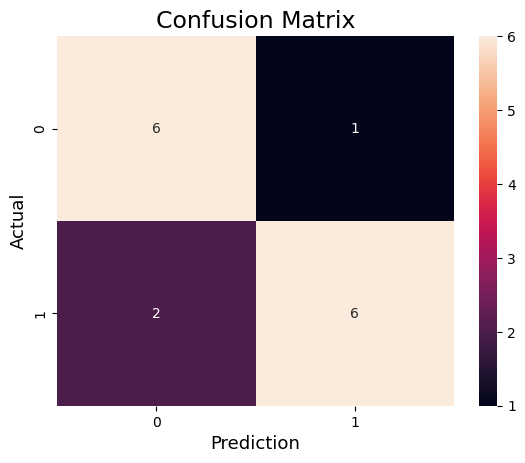

/tmp/ipykernel_977685/570206594.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_notquant = pd.concat([data_notquant, pd.DataFrame([row])], ignore_index=True)


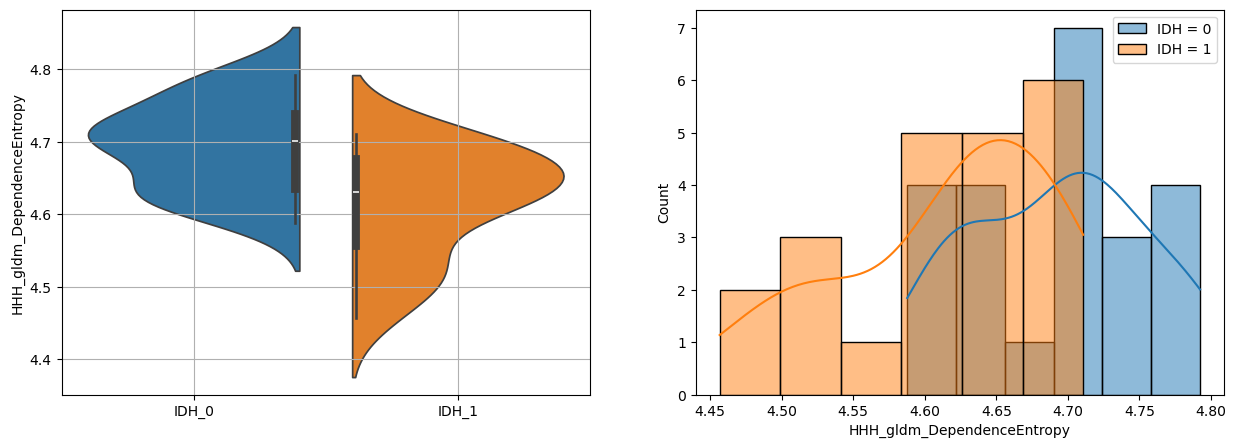

len train: 30
len test: 15


/tmp/ipykernel_977685/1586495699.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(d, bins = 1)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/li

,Accuracy,Precisione,Recall,F1_score
RidgeClassifier,0.533333,1.000000,0.125000,0.222222
RidgeClassifierCV,0.533333,0.571429,0.500000,0.533333
SGDClassifier,0.466667,0.000000,0.000000,0.000000
PassiveAggressiveClassifier,0.466667,0.000000,0.000000,0.000000
GaussianProcessClassifier,0.466667,0.000000,0.000000,0.000000
RandomForest,0.533333,0.555556,0.625000,0.588235
AdaBoostClassifier,0.533333,0.555556,0.625000,0.588235
BaggingClassifier,0.466667,0.500000,0.500000,0.500000
ExtraTreesClassifier,0.466667,0.500000,0.500000,0.500000
GradientBoostingClassifier,0.533333,0.555556,0.625000,0.588235


/opt/conda/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Best model: KNeighbors
pred = [0 1 1 0 1 1 0 1 0 0 0 0 0 1 1]
true = [1 1 1 0 1 0 0 0 0 0 0 1 1 1 1]
---------  ---------
           Модель PR
accuracy   0.67
precision  0.71
recall     0.62
F1_score   0.67
---------  ---------


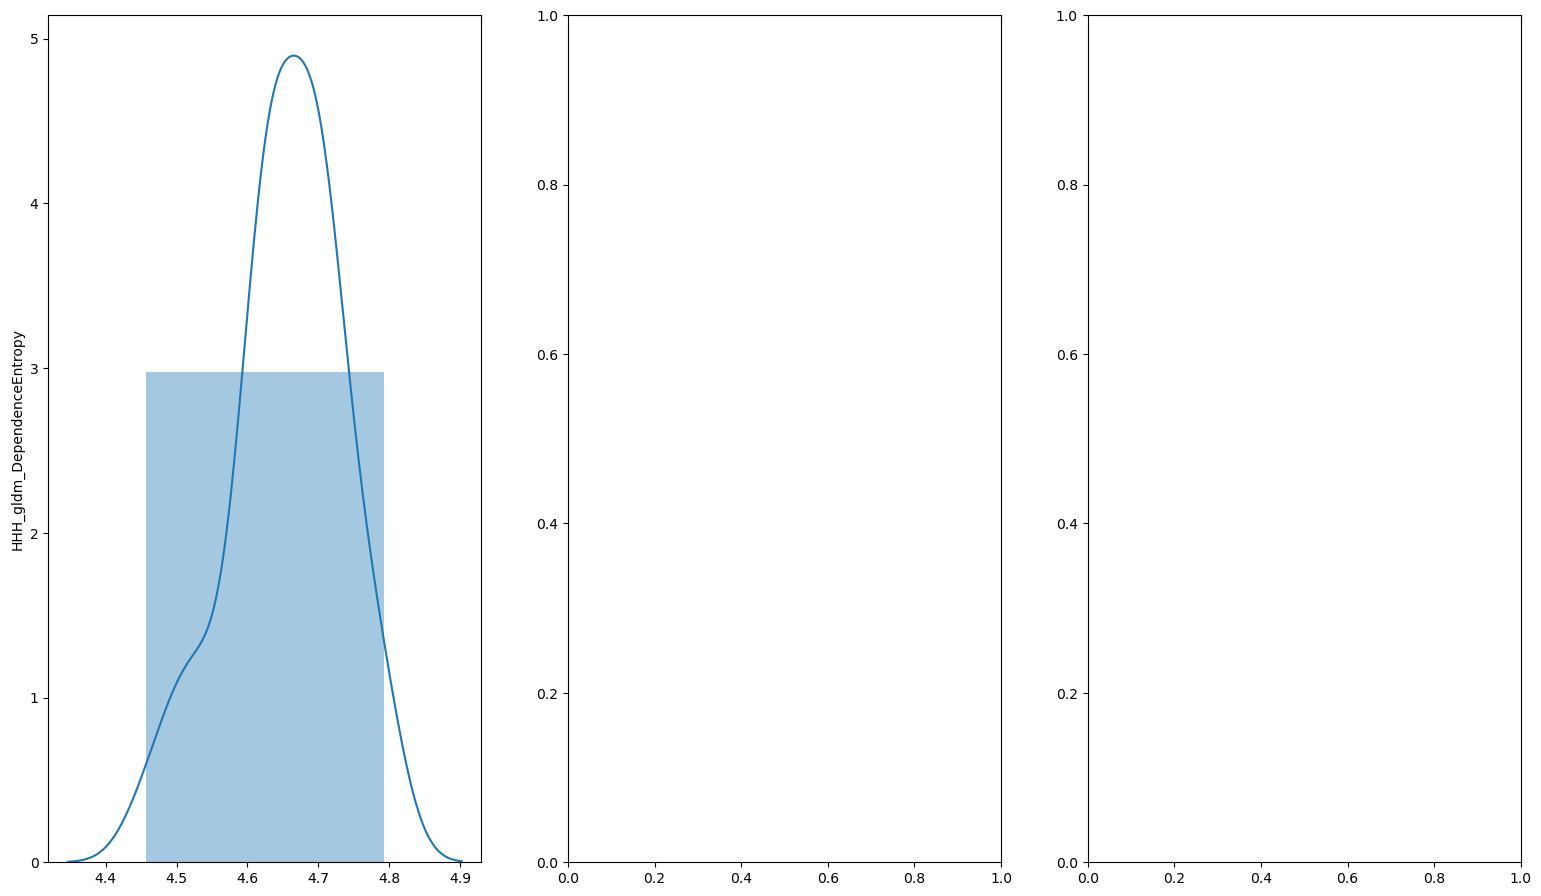

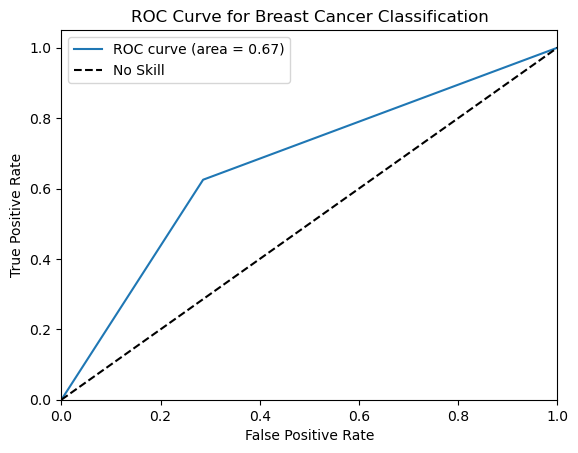

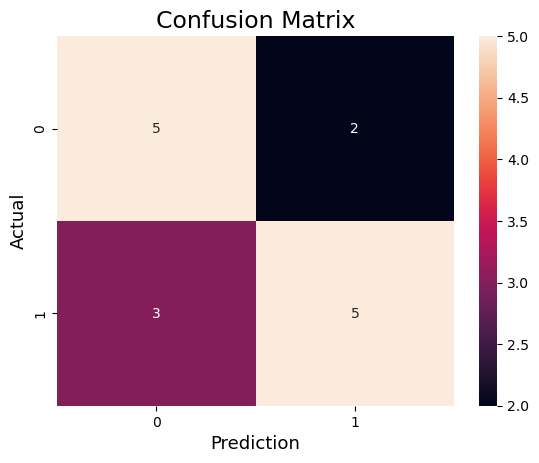

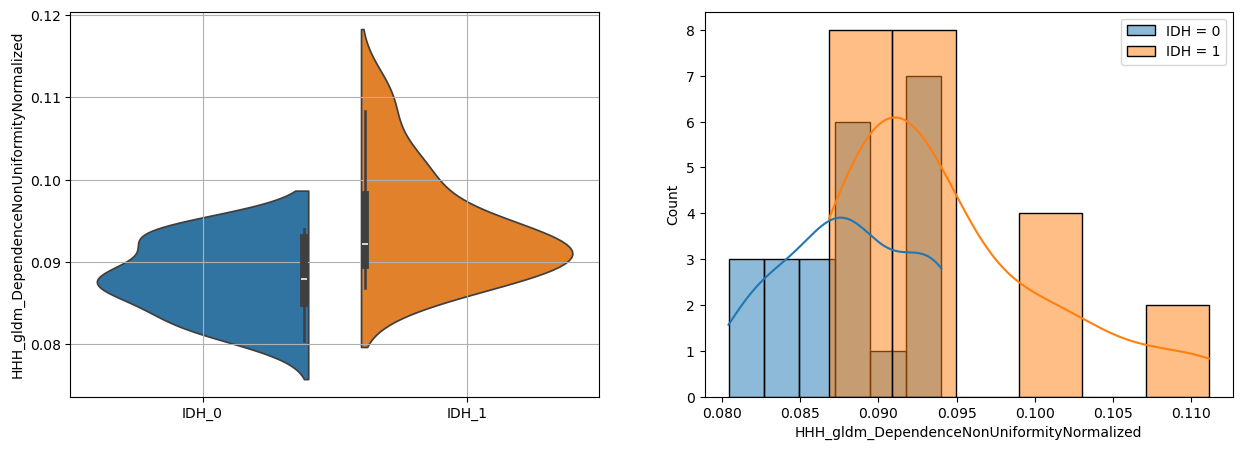

len train: 30
len test: 15


/tmp/ipykernel_977685/1586495699.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(d, bins = 1)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

,Accuracy,Precisione,Recall,F1_score
RidgeClassifier,0.466667,0.000000,0.000000,0.000000
RidgeClassifierCV,0.466667,0.000000,0.000000,0.000000
SGDClassifier,0.533333,0.533333,1.000000,0.695652
PassiveAggressiveClassifier,0.533333,0.533333,1.000000,0.695652
GaussianProcessClassifier,0.466667,0.000000,0.000000,0.000000
RandomForest,0.666667,0.714286,0.625000,0.666667
AdaBoostClassifier,0.666667,0.714286,0.625000,0.666667
BaggingClassifier,0.600000,0.666667,0.500000,0.571429
ExtraTreesClassifier,0.666667,0.714286,0.625000,0.666667
GradientBoostingClassifier,0.666667,0.714286,0.625000,0.666667


/opt/conda/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Best model: KNeighbors
pred = [1 1 1 1 0 0 0 0 0 0 0 0 0 1 1]
true = [1 1 1 0 1 0 0 0 0 0 0 1 1 1 1]
---------  ---------
           Модель PR
accuracy   0.73
precision  0.83
recall     0.62
F1_score   0.71
---------  ---------


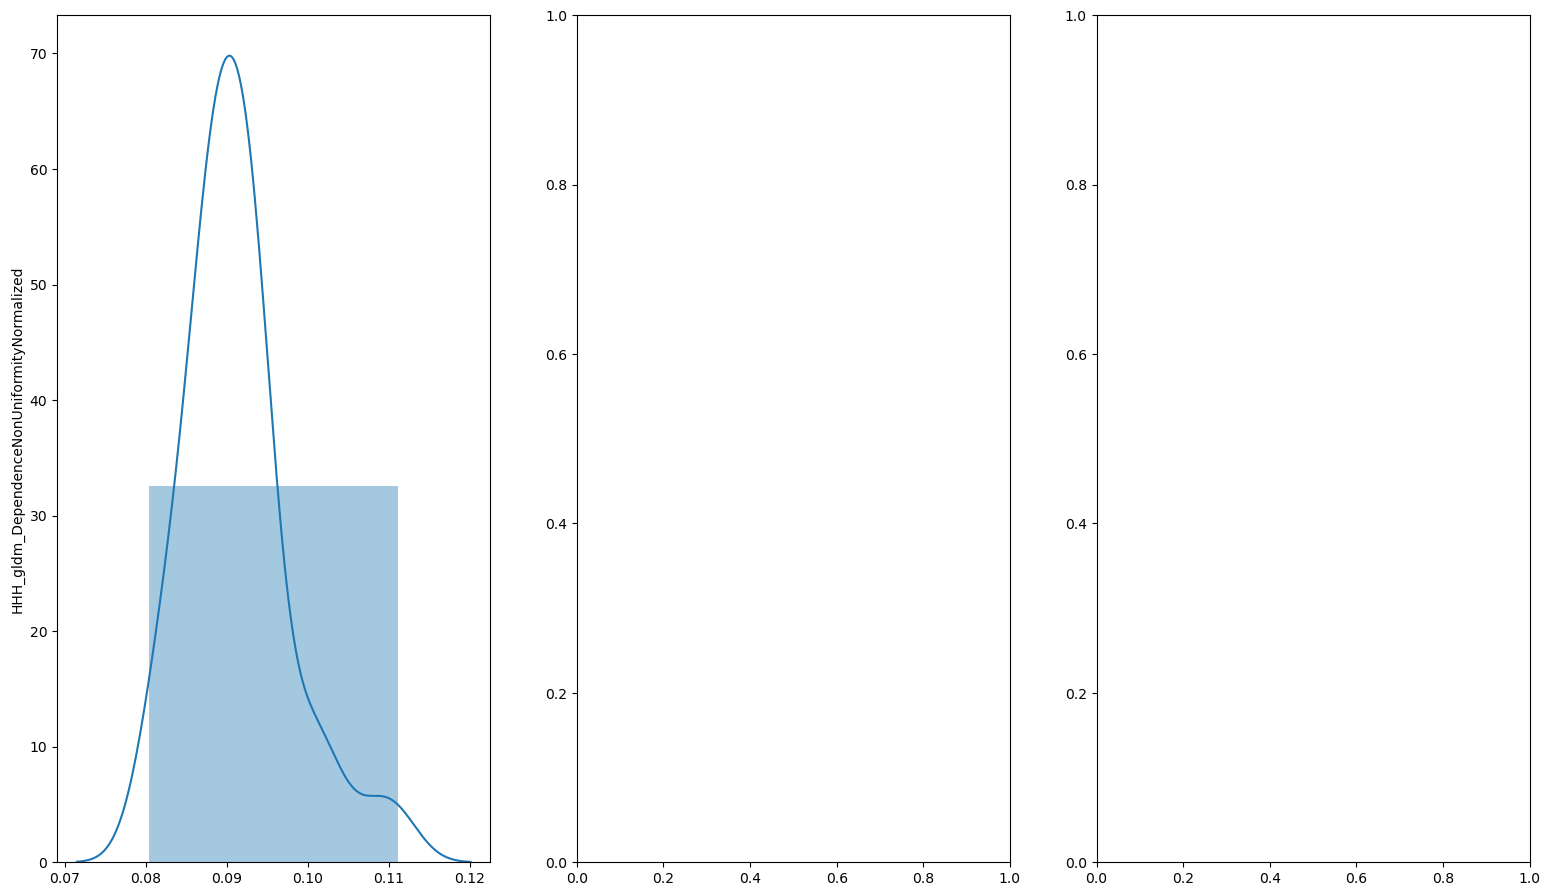

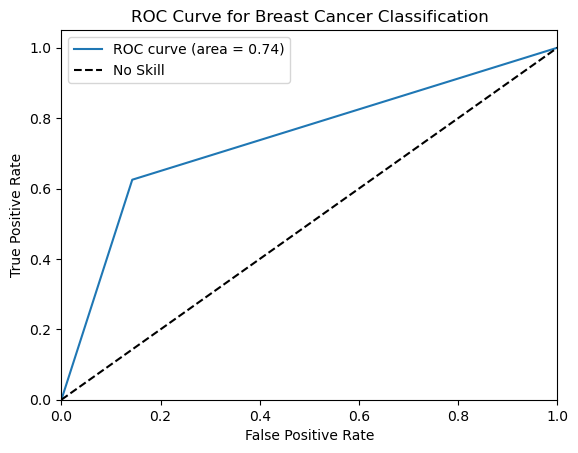

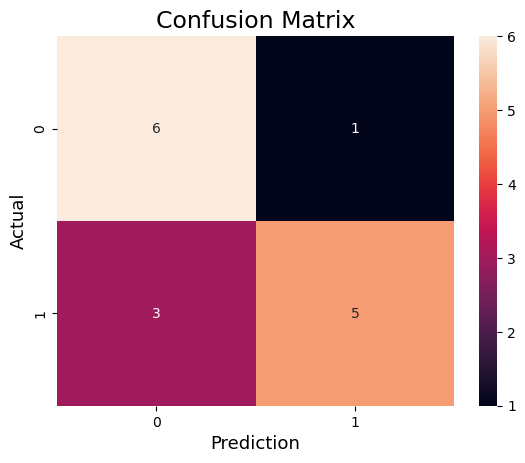

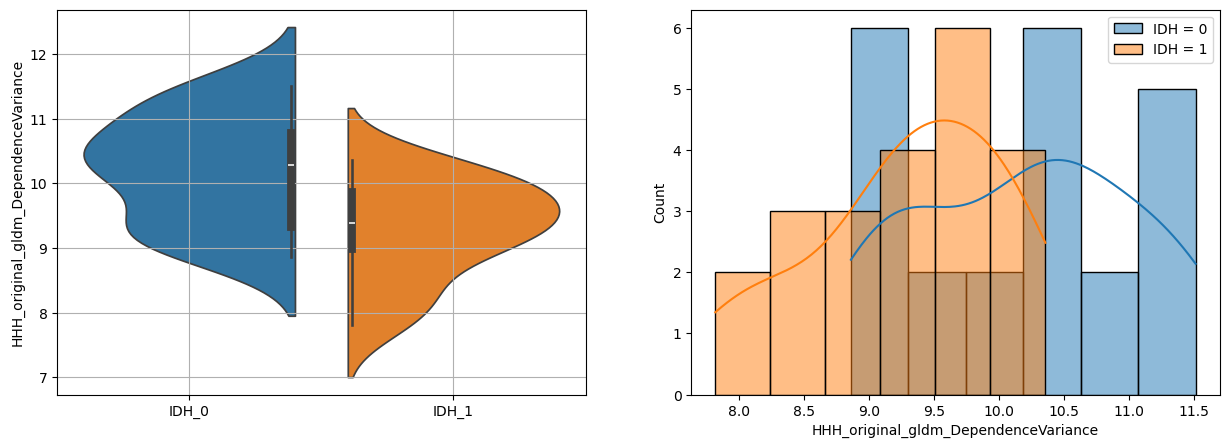

len train: 30
len test: 15


/tmp/ipykernel_977685/1586495699.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(d, bins = 1)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/li

,Accuracy,Precisione,Recall,F1_score
RidgeClassifier,0.533333,0.571429,0.500000,0.533333
RidgeClassifierCV,0.533333,0.571429,0.500000,0.533333
SGDClassifier,0.533333,0.533333,1.000000,0.695652
PassiveAggressiveClassifier,0.533333,0.533333,1.000000,0.695652
GaussianProcessClassifier,0.533333,0.571429,0.500000,0.533333
RandomForest,0.533333,0.600000,0.375000,0.461538
AdaBoostClassifier,0.533333,0.600000,0.375000,0.461538
BaggingClassifier,0.533333,0.600000,0.375000,0.461538
ExtraTreesClassifier,0.533333,0.600000,0.375000,0.461538
GradientBoostingClassifier,0.533333,0.600000,0.375000,0.461538


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best model: RidgeClassifier
pred = [1 1 0 1 0 1 0 1 0 0 0 0 1 1 0]
true = [1 1 1 0 1 0 0 0 0 0 0 1 1 1 1]
---------  ---------
           Модель PR
accuracy   0.53
precision  0.57
recall     0.50
F1_score   0.53
---------  ---------


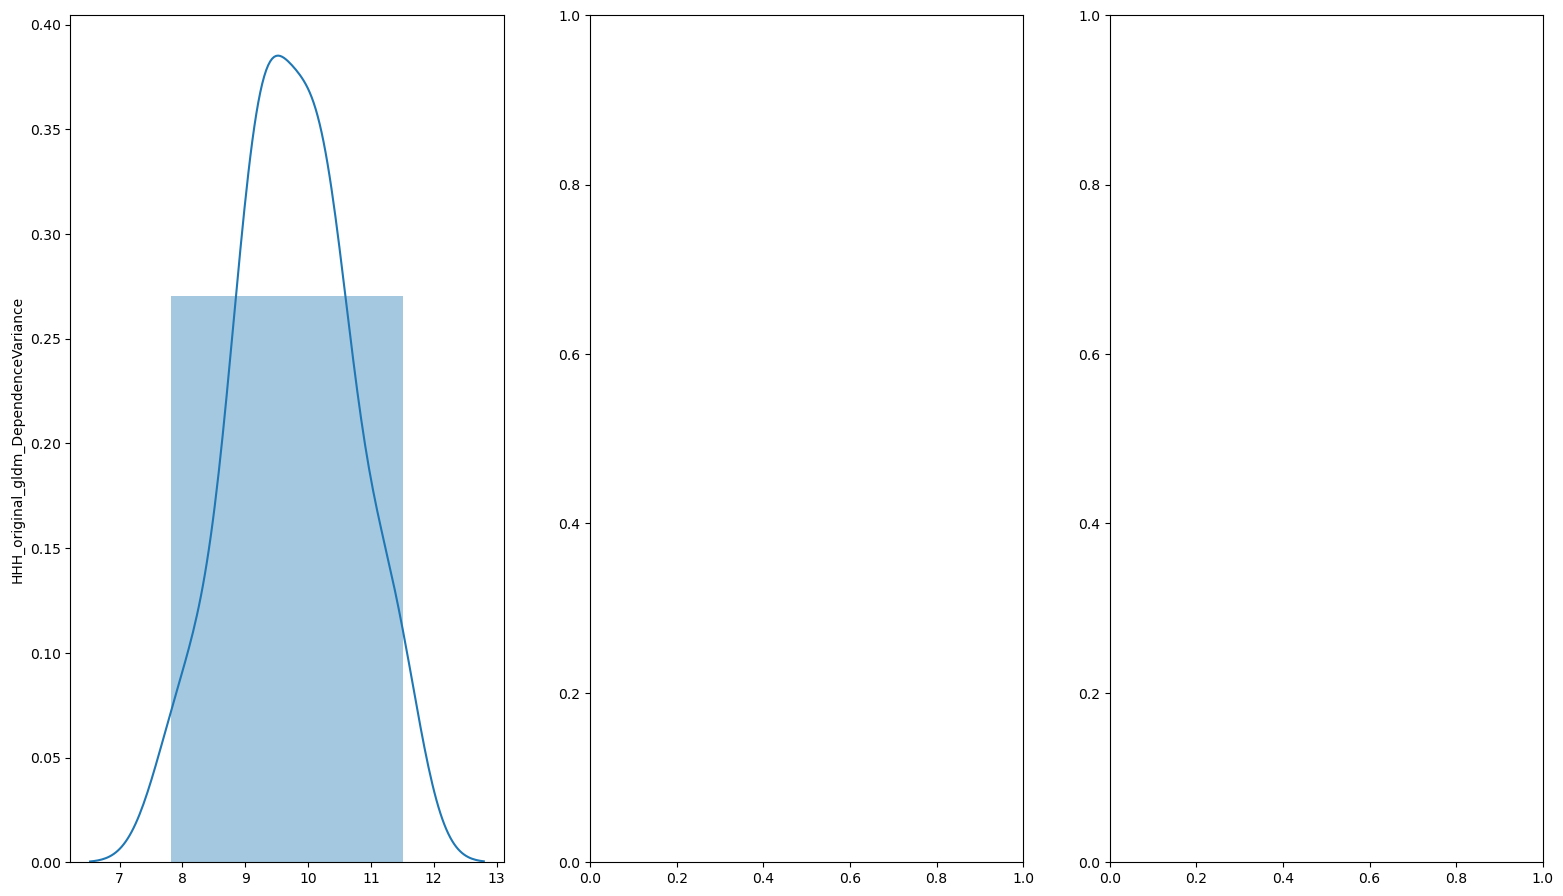

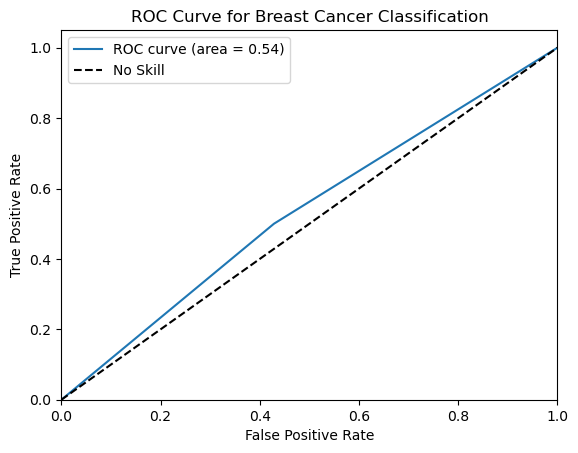

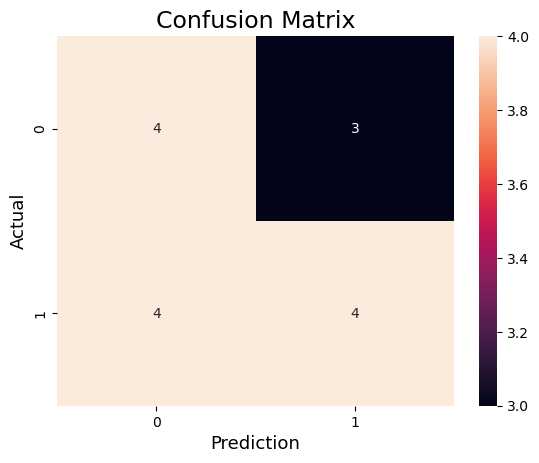

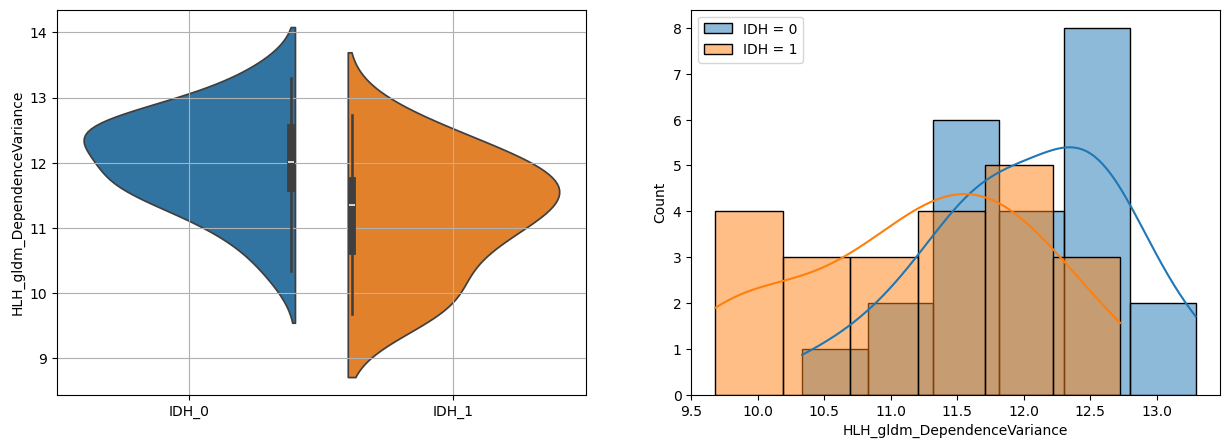

len train: 30
len test: 15


/tmp/ipykernel_977685/1586495699.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(d, bins = 1)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/li

,Accuracy,Precisione,Recall,F1_score
RidgeClassifier,0.800000,0.857143,0.750000,0.800000
RidgeClassifierCV,0.800000,0.857143,0.750000,0.800000
SGDClassifier,0.466667,0.000000,0.000000,0.000000
PassiveAggressiveClassifier,0.533333,0.533333,1.000000,0.695652
GaussianProcessClassifier,0.800000,0.857143,0.750000,0.800000
RandomForest,0.466667,0.500000,0.500000,0.500000
AdaBoostClassifier,0.466667,0.500000,0.500000,0.500000
BaggingClassifier,0.400000,0.428571,0.375000,0.400000
ExtraTreesClassifier,0.466667,0.500000,0.500000,0.500000
GradientBoostingClassifier,0.466667,0.500000,0.500000,0.500000


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best model: RidgeClassifier
pred = [1 1 0 0 1 1 0 0 0 0 0 0 1 1 1]
true = [1 1 1 0 1 0 0 0 0 0 0 1 1 1 1]
---------  ---------
           Модель PR
accuracy   0.80
precision  0.86
recall     0.75
F1_score   0.80
---------  ---------


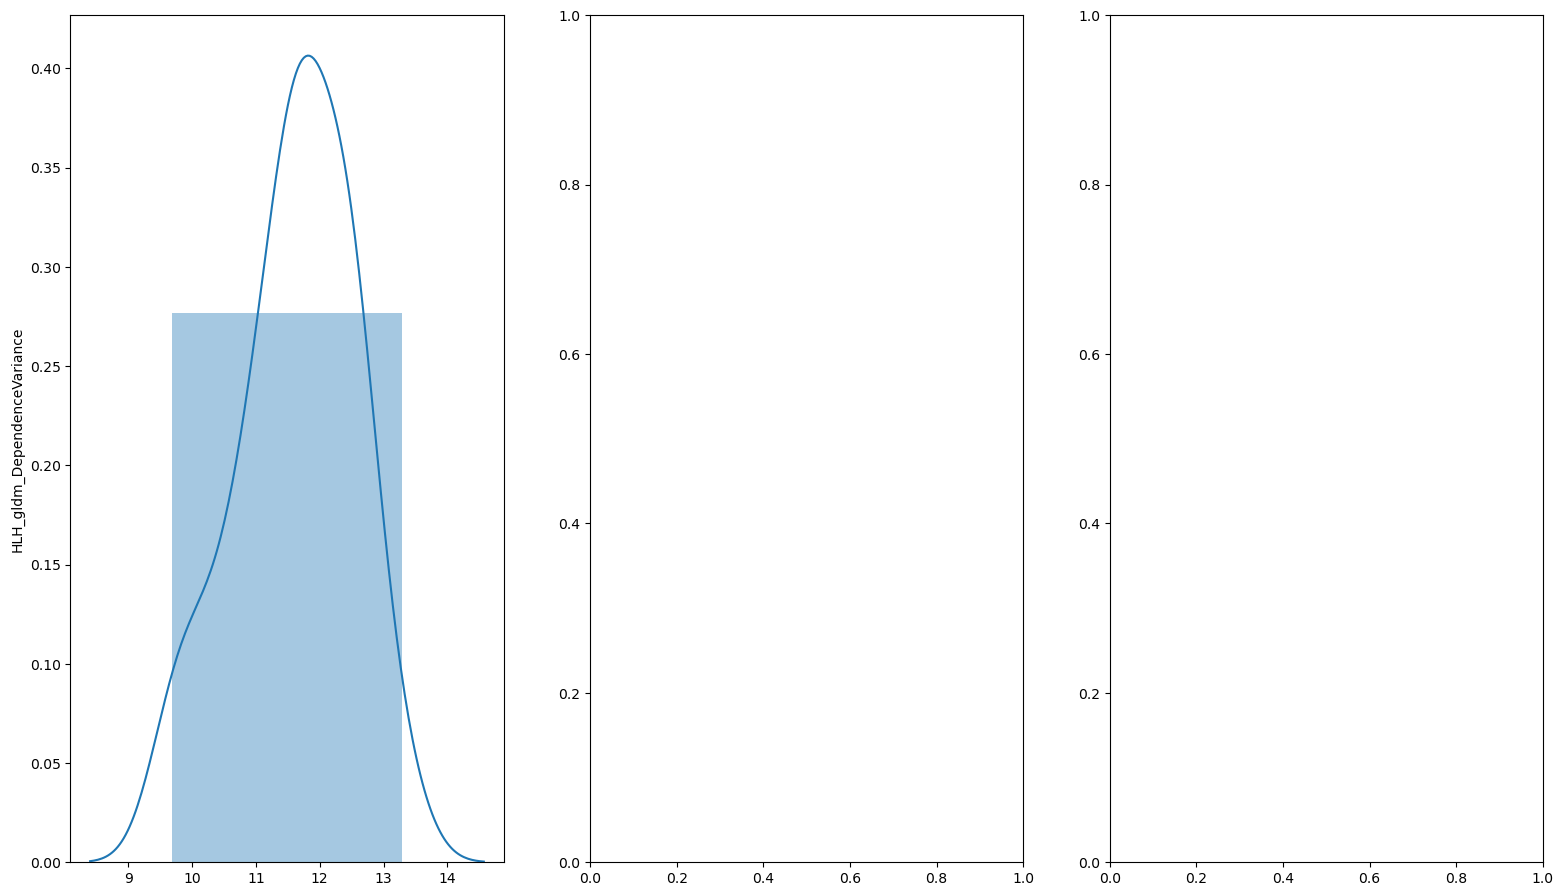

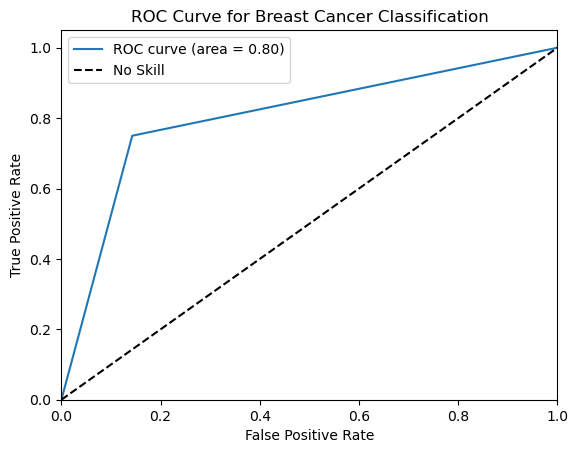

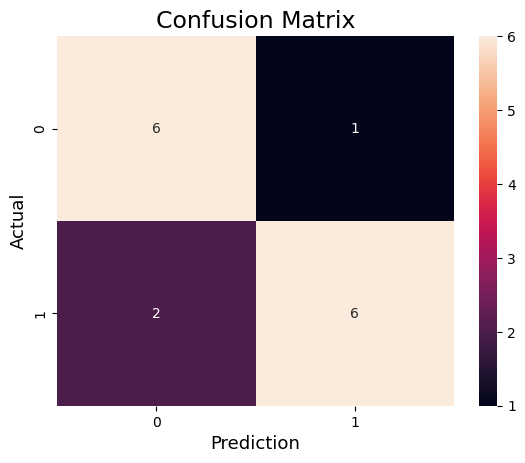

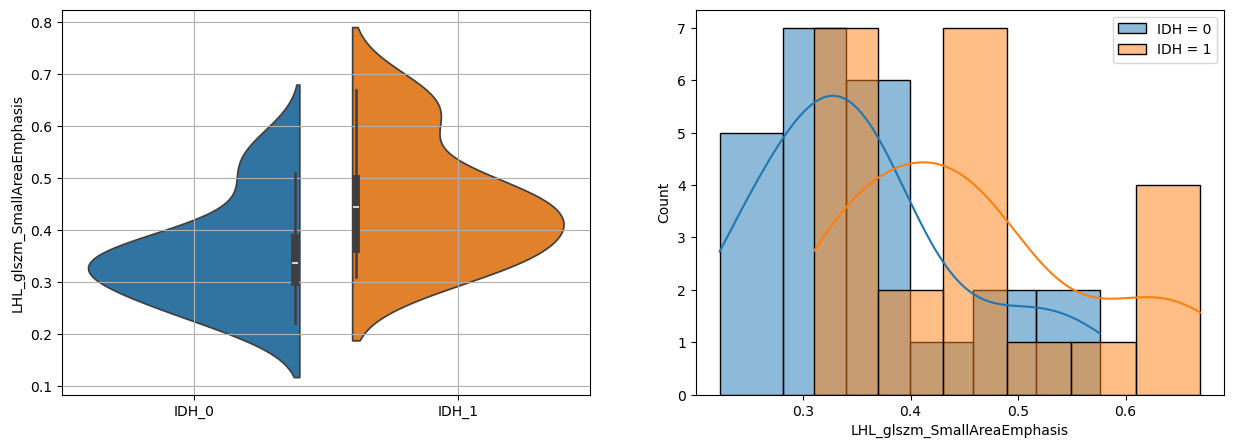

len train: 30
len test: 15


/tmp/ipykernel_977685/1586495699.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(d, bins = 1)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/li

,Accuracy,Precisione,Recall,F1_score
RidgeClassifier,0.600000,0.666667,0.500000,0.571429
RidgeClassifierCV,0.666667,0.666667,0.750000,0.705882
SGDClassifier,0.533333,0.538462,0.875000,0.666667
PassiveAggressiveClassifier,0.666667,0.666667,0.750000,0.705882
GaussianProcessClassifier,0.666667,1.000000,0.375000,0.545455
RandomForest,0.533333,0.555556,0.625000,0.588235
AdaBoostClassifier,0.533333,0.555556,0.625000,0.588235
BaggingClassifier,0.600000,0.600000,0.750000,0.666667
ExtraTreesClassifier,0.533333,0.555556,0.625000,0.588235
GradientBoostingClassifier,0.533333,0.555556,0.625000,0.588235


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best model: RidgeClassifierCV
pred = [1 1 1 1 0 0 0 1 1 0 0 0 1 1 1]
true = [1 1 1 0 1 0 0 0 0 0 0 1 1 1 1]
---------  ---------
           Модель PR
accuracy   0.67
precision  0.67
recall     0.75
F1_score   0.71
---------  ---------


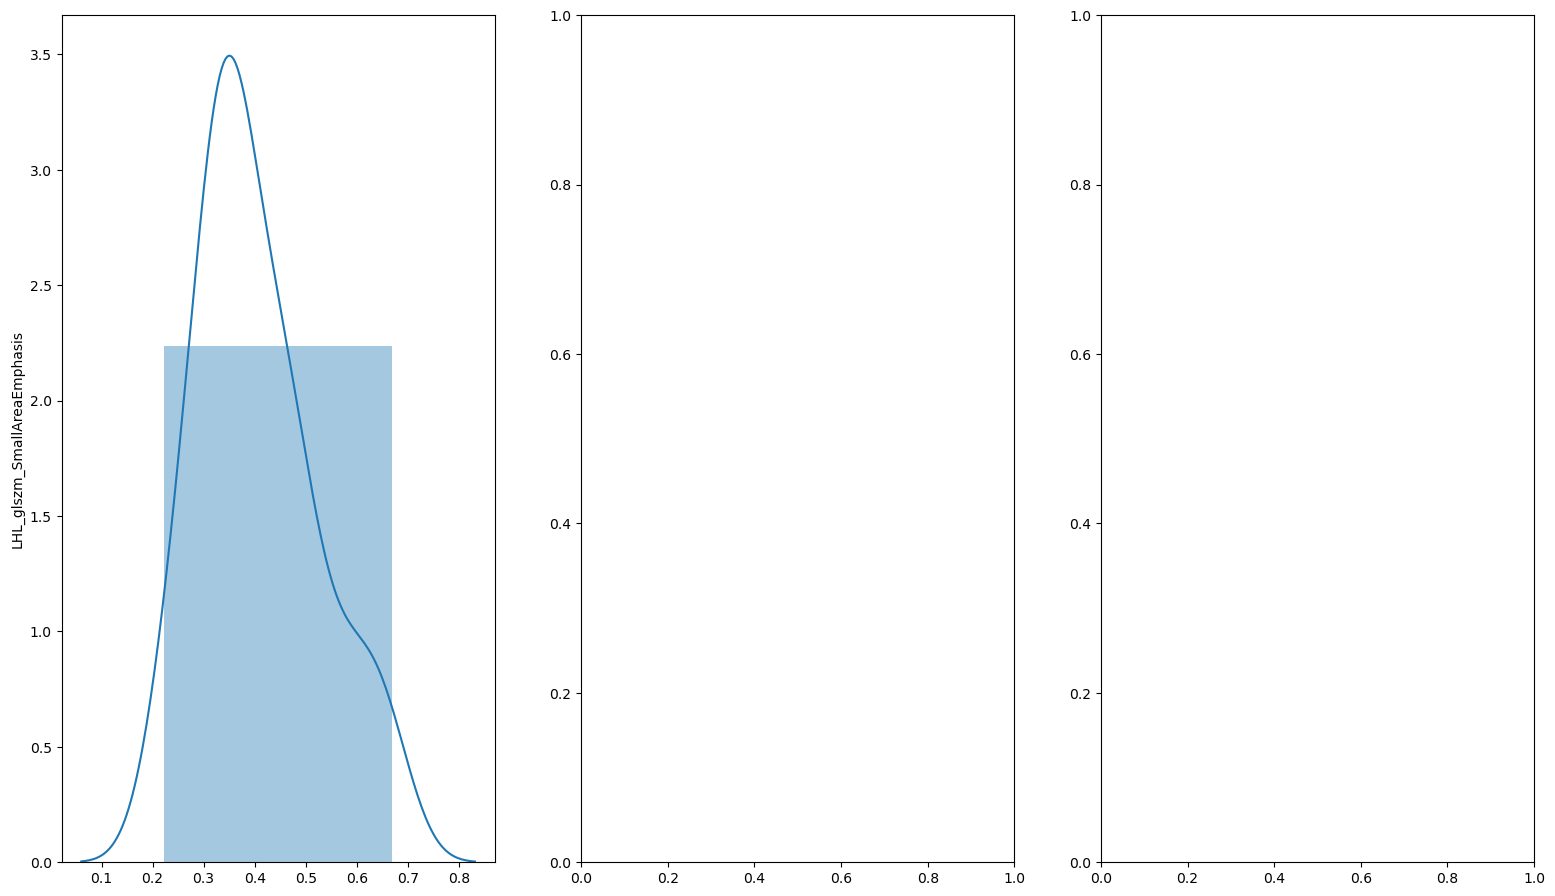

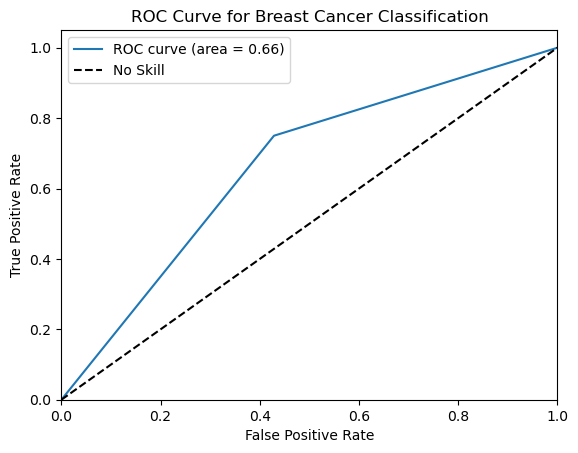

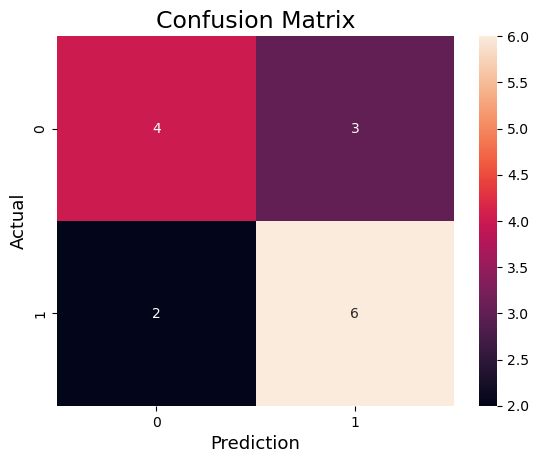

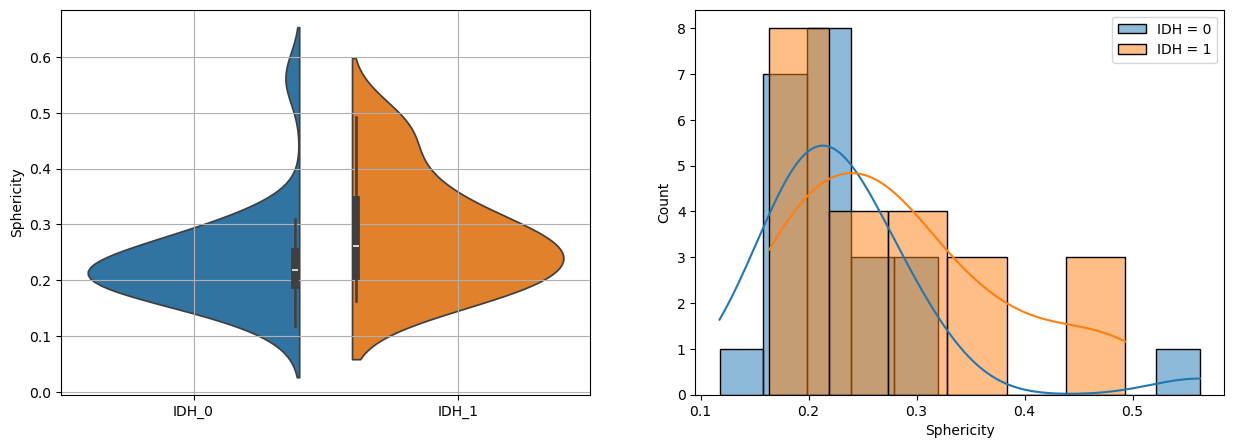

len train: 30
len test: 15


/tmp/ipykernel_977685/1586495699.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(d, bins = 1)
/tmp/ipykernel_977685/1586495699.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(d, bins = 1)
/tmp/ipykernel_977685/1586495699.py:32: UserWarning: 

`distplot` is a deprecated function

,Accuracy,Precisione,Recall,F1_score
RidgeClassifier,0.600000,0.625000,0.625000,0.625000
RidgeClassifierCV,0.666667,0.666667,0.750000,0.705882
SGDClassifier,0.666667,0.615385,1.000000,0.761905
PassiveAggressiveClassifier,0.466667,0.000000,0.000000,0.000000
GaussianProcessClassifier,0.600000,0.625000,0.625000,0.625000
RandomForest,0.733333,0.750000,0.750000,0.750000
AdaBoostClassifier,0.733333,0.750000,0.750000,0.750000
BaggingClassifier,0.666667,0.666667,0.750000,0.705882
ExtraTreesClassifier,0.800000,0.777778,0.875000,0.823529
GradientBoostingClassifier,0.666667,0.666667,0.750000,0.705882


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best model: ExtraTreesClassifier
pred = [1 1 1 1 1 0 0 1 0 0 0 0 1 1 1]
true = [1 1 1 0 1 0 0 0 0 0 0 1 1 1 1]
---------  ---------
           Модель PR
accuracy   0.80
precision  0.78
recall     0.88
F1_score   0.82
---------  ---------


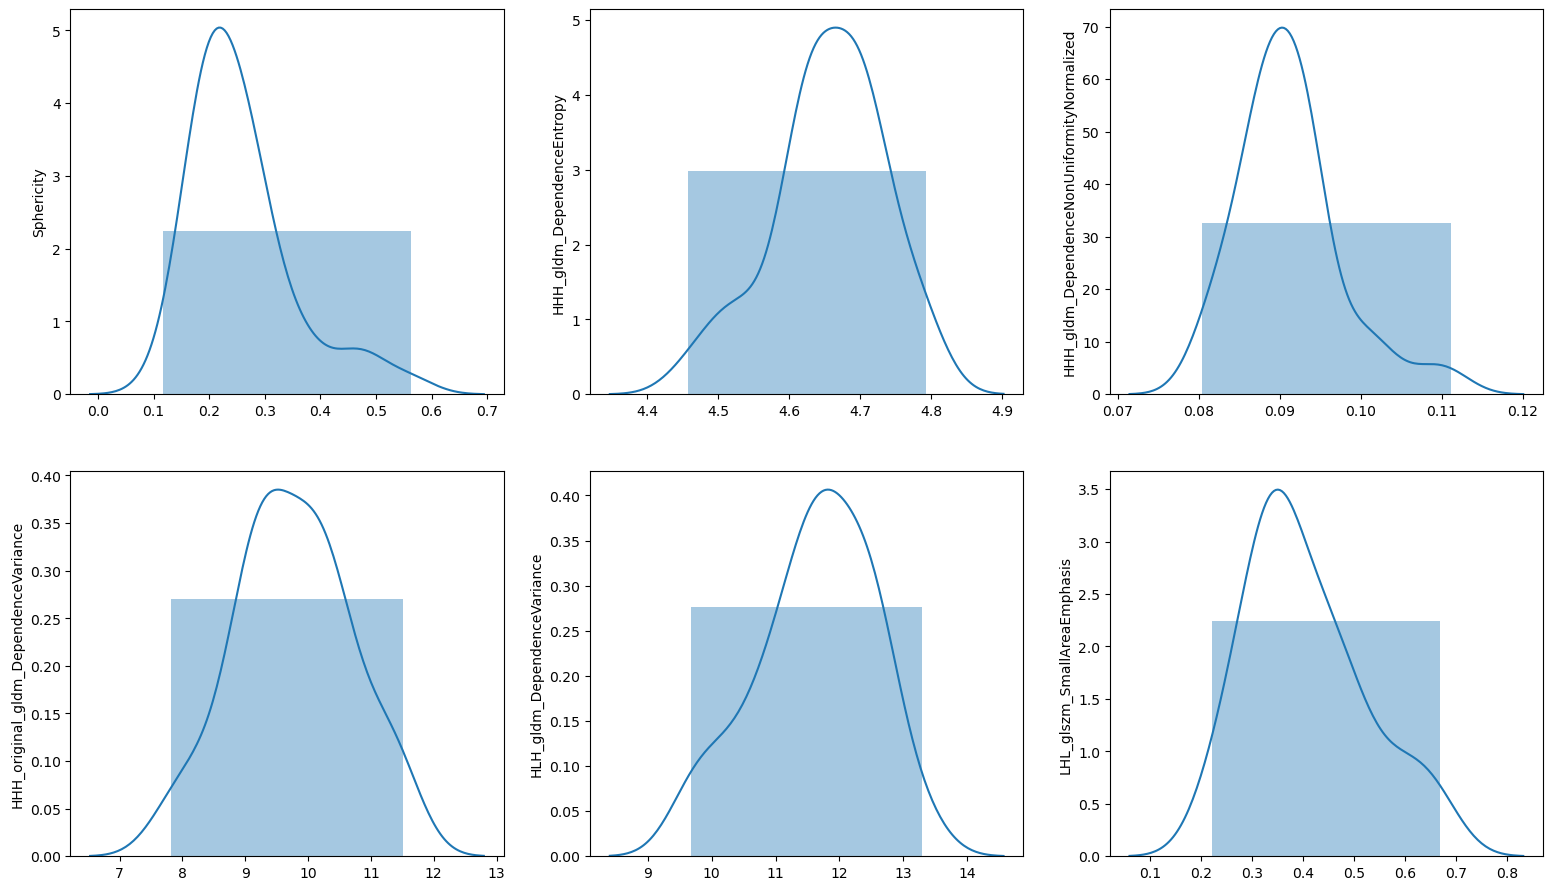

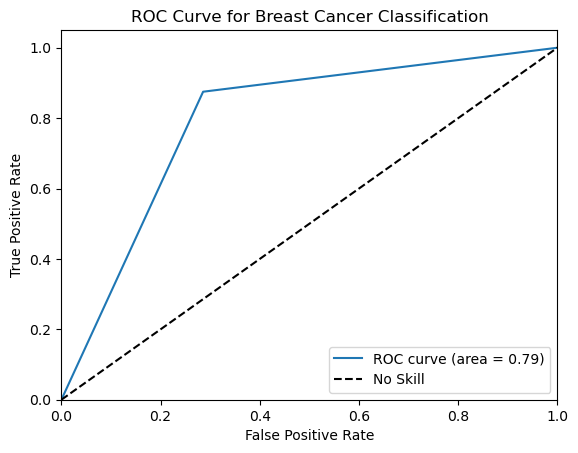

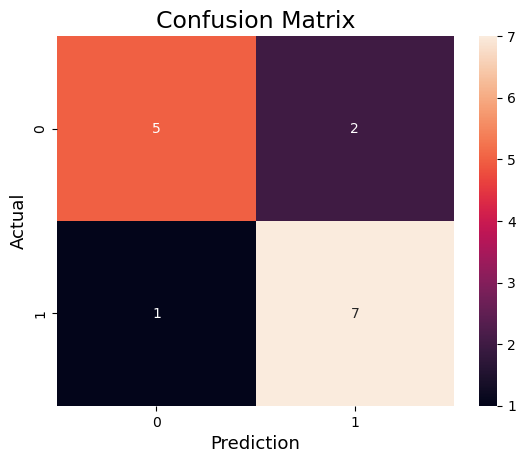

In [93]:
data_notquant = pd.DataFrame(columns=['Feature','Model', 'Accuracy', 'Precisione', 'Recall', 'F1_score', 'ROC'])
for name in feature_names:
    row = statistics(df, [name], emissions = False)
    data_notquant = pd.concat([data_notquant, pd.DataFrame([row])], ignore_index=True)

row = statistics(df, feature_names, emissions = False)
data_notquant = pd.concat([data_notquant, pd.DataFrame([row])], ignore_index=True)
data_notquant.loc[data_notquant.index[-1], 'Feature'] = 'Whole feature'
data_notquant.to_csv('./model_data/norm_scale_nq.csv')

In [94]:
data_notquant.style.apply(h_max)

,Feature,Model,Accuracy,Precisione,Recall,F1_score,ROC
0,Sphericity,RandomForest,0.800000,0.857143,0.750000,0.800000,0.803571
1,HHH_gldm_DependenceEntropy,KNeighbors,0.666667,0.714286,0.625000,0.666667,0.669643
2,HHH_gldm_DependenceNonUniformityNormalized,KNeighbors,0.733333,0.833333,0.625000,0.714286,0.741071
3,HHH_original_gldm_DependenceVariance,RidgeClassifier,0.533333,0.571429,0.500000,0.533333,0.535714
4,HLH_gldm_DependenceVariance,RidgeClassifier,0.800000,0.857143,0.750000,0.800000,0.803571
5,LHL_glszm_SmallAreaEmphasis,RidgeClassifierCV,0.666667,0.666667,0.750000,0.705882,0.660714
6,Whole feature,ExtraTreesClassifier,0.800000,0.777778,0.875000,0.823529,0.794643
